In [32]:
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn

### 2. NLP model

In [3]:
#df = pd.read_pickle('data/prp_df.pkl')

with open('/kaggle/input/prepared-df-4-cl-cup/prp_df_4.pkl', 'rb') as pkl:
    df = pickle.load(pkl)

### Columns:

* **text_id** - ID of initial text
* **text** - initial raw text
* **comment** - initial raw comment to text
* **prp_text** - preprocessed cleaned text
* **prp_com** - preprocessed cleaned comment
* **score** - initial labels
* **text_words_qty** - number of words in preprocessed text
* **comment_words_qty** - number of words in preprocessed comment
* **repeat_words** - number of repeated words in text and in comment
* **repeat_rate_words** - ratio of repeated words to the number of words in comment
* **link** - if there is a link in comment
* **quoted** - if there is a quotaion in comment
* **wr_sum** - sum of word weights in comment (weight are based on popularity)
* **wr_len** - number of popular words in comment
* **wr_rate** - ratio of *wr_sum* to *wr_len*
* **wr_rate_tot** - ratio of *wr_sum* to *comment_words_qty*

### Making labels for binary classification

In [4]:
df['label'] = np.where(df['score']==0, 1, 0) # mark as 1 only best comments
df['label_1'] = np.where(df['score']==4, 1, 0) # mark as 1 only worst comments

In [5]:
df.head(6)

,text_id,text,comment,prp_text,prp_com,score,text_words_qty,comment_words_qty,repeat_words,repeat_rate_words,link,quoted,wr_sum,wr_len,wr_rate,wr_rate_tot,label,label_1
0,0,0^0,- &quot;0^0. Why? Because mathematicians said ...,0 0,quot 0 0 mathematician said really true quot d...,3,2,35,1,0.028571,0,1,292342,17,17196.587891,8352.628906,0,0
1,0,0^0,It&#x27;s very important to note here that 0^0...,0 0,x27 important note 0 0 1 shorthand truth mathe...,0,2,174,1,0.005747,0,1,1005446,64,15710.093750,5778.425293,1,0
2,0,0^0,A word from Knuth on the matter (warning: PDF)...,0 0,word knuth matter warning pdf http x2f x2f arx...,4,2,19,0,0.000000,1,0,94678,7,13525.428711,4983.052734,0,1
3,0,0^0,Students: Let&#x27;s come up with some crazy p...,0 0,student let x27 come crazy proof based individ...,1,2,28,0,0.000000,0,0,270892,19,14257.473633,9674.713867,0,0
4,0,0^0,The real problem here is that x^y is a single ...,0 0,real problem x single shorthand refers fundame...,2,2,83,1,0.012048,0,0,345465,27,12795.000000,4162.229004,0,0
5,1,The $0.001 DIY iPhone 4 Antenna Fix,Is this a joke that I'm not getting? Scotch ta...,0 001 diy iphone 4 antenna fix,joke getting scotch tape really problem real f...,0,7,23,1,0.043478,0,0,247597,14,17685.500000,10765.086914,1,0


In [6]:
df['text'] = df['text'] + ' ' + df['comment']

In [7]:
df = df[['text_id', 'text', 'score', 'label', 'label_1']]

In [8]:
df.head(6)

,text_id,text,score,label,label_1
0,0,0^0 - &quot;0^0. Why? Because mathematicians s...,3,0,0
1,0,0^0 It&#x27;s very important to note here that...,0,1,0
2,0,0^0 A word from Knuth on the matter (warning: ...,4,0,1
3,0,0^0 Students: Let&#x27;s come up with some cra...,1,0,0
4,0,0^0 The real problem here is that x^y is a sin...,2,0,0
5,1,The $0.001 DIY iPhone 4 Antenna Fix Is this a ...,0,1,0


### Spliting the dataset

To speed up training we will use 30% of dataset.  
20% we will keep for test.

In [9]:
total_texts = df['text_id'].max() + 1
print(f'Total number of texts: {total_texts}')
print(f'30% of dataset, text_index <= {total_texts*0.3:.0f}')
print(f'20% for test, {total_texts*0.3:.0f} > text_index <= {total_texts*0.5:.0f}')

Total number of texts: 85987
30% of dataset, text_index <= 25796
20% for validation, 25796 > text_index <= 42994


In [10]:
df_train = df[df['text_id']<=25796]
df_test = df[(df['text_id']>25796)&(df['text_id']<=42994)]

### a. Make embeddings:

In [11]:
from transformers import AutoTokenizer
from transformers import BertModel  # https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertModel
from transformers import RobertaModel  # https://huggingface.co/docs/transformers/model_doc/roberta#transformers.RobertaModel
from transformers import DistilBertModel  # https://huggingface.co/docs/transformers/model_doc/distilbert#transformers.DistilBertModel


def get_model(model_name):
    assert model_name in ['bert', 'roberta', 'distilbert']
    
    checkpoint_names = {
        'bert': 'bert-base-cased',  # https://huggingface.co/bert-base-cased
        'roberta': 'roberta-base',  # https://huggingface.co/roberta-base
        'distilbert': 'distilbert-base-cased'  # https://huggingface.co/distilbert-base-cased
    }
    
    model_classes = {
        'bert': BertModel,
        'roberta': RobertaModel,
        'distilbert': DistilBertModel
    }
    
    return AutoTokenizer.from_pretrained(checkpoint_names[model_name]), model_classes[model_name].from_pretrained(checkpoint_names[model_name])

In [12]:
tokenizer, model = get_model('bert')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
# make Dataset using 30% of initial Data to speedUp process.

import datasets

train_df = df_train[['text', 'label']]

test_df = df_test[['text', 'label']]

train_dataset = datasets.Dataset.from_pandas(train_df)
test_dataset = datasets.Dataset.from_pandas(test_df)
my_dataset_dict = datasets.DatasetDict({"train":train_dataset,"test":test_dataset})

In [19]:
from tqdm import tqdm

@torch.inference_mode()
def get_embeddings_labels(model, loader):
    model.eval()
    
    total_embeddings = []
    labels = []
    
    for batch in tqdm(loader):
        labels.append(batch['labels'].unsqueeze(1))

        batch = {key: batch[key].to(device) for key in ['attention_mask', 'input_ids']}

        embeddings = model(**batch)['last_hidden_state'][:, 0, :]

        total_embeddings.append(embeddings.cpu())

    return torch.cat(total_embeddings, dim=0), torch.cat(labels, dim=0).to(torch.float32)

In [20]:
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [21]:
def tokenization(example):
    return tokenizer.batch_encode_plus(example['text'], add_special_tokens=True, return_token_type_ids=False, truncation=True)

train_dataset = my_dataset_dict['train'].map(tokenization, batched=True)
test_dataset = my_dataset_dict['test'].map(tokenization, batched=True)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

train_loader = DataLoader(train_dataset, batch_size=64, collate_fn=data_collator, pin_memory=True, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=data_collator, pin_memory=True, shuffle=False)

  0%|          | 0/129 [00:00<?, ?ba/s]

  0%|          | 0/86 [00:00<?, ?ba/s]

In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

cuda:0
Tesla P100-PCIE-16GB


In [23]:
train_embeddings, train_labels = get_embeddings_labels(model.to(device), train_loader)

100%|██████████| 2016/2016 [33:34<00:00,  1.00it/s]


In [28]:
test_embeddings, test_labels = get_embeddings_labels(model, test_loader)

100%|██████████| 1344/1344 [22:10<00:00,  1.01it/s]


In [29]:
import pickle

# Saving embeddings

with open('train_embeddings.pickle', 'wb') as pkl:
    pickle.dump(train_embeddings, pkl)
    
with open('test_embeddings.pickle', 'wb') as pkl:
    pickle.dump(test_embeddings, pkl)

In [68]:
from torch.utils.data import TensorDataset
from torch.utils.data import random_split


dataset = TensorDataset(torch.cat([train_embeddings, test_embeddings], dim=0), torch.cat([train_labels, test_labels], dim=0))

train_dataset, test_dataset = random_split(dataset, (int(len(dataset) * 0.9), len(dataset) - int(len(dataset) * 0.9)))

train_loader = DataLoader(train_dataset, batch_size=128, pin_memory=True, shuffle=False)
valid_loader = DataLoader(test_dataset, batch_size=128, pin_memory=True, shuffle=False)

In [69]:
little_model = nn.Sequential(
    nn.Linear(768, 768),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(768, 1)
)

In [70]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc


def train(model):
    model.train()

    train_loss = 0
    train_accuracy = 0

    for x, y in tqdm(train_loader, desc='text'):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        train_loss += loss.item()
        train_accuracy += binary_accuracy(output, y).cpu()

        loss.backward()

        optimizer.step()

    train_loss /= len(train_loader)
    train_accuracy /= len(train_loader)

    return train_loss, train_accuracy

In [71]:
@torch.inference_mode()
def evaluate(model, loader):
    model.eval()

    total_loss = 0
    total_accuracy = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()
        total_accuracy += binary_accuracy(output, y).cpu()

    total_loss /= len(loader)
    total_accuracy /= len(loader)

    return total_loss, total_accuracy

In [72]:
import matplotlib.pyplot as plt
from IPython.display import clear_output


def plot_stats(
    train_loss: [float],
    valid_loss: [float],
    train_accuracy: [float],
    valid_accuracy: [float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()

In [145]:
def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model)
        valid_loss, valid_accuracy = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title

        )

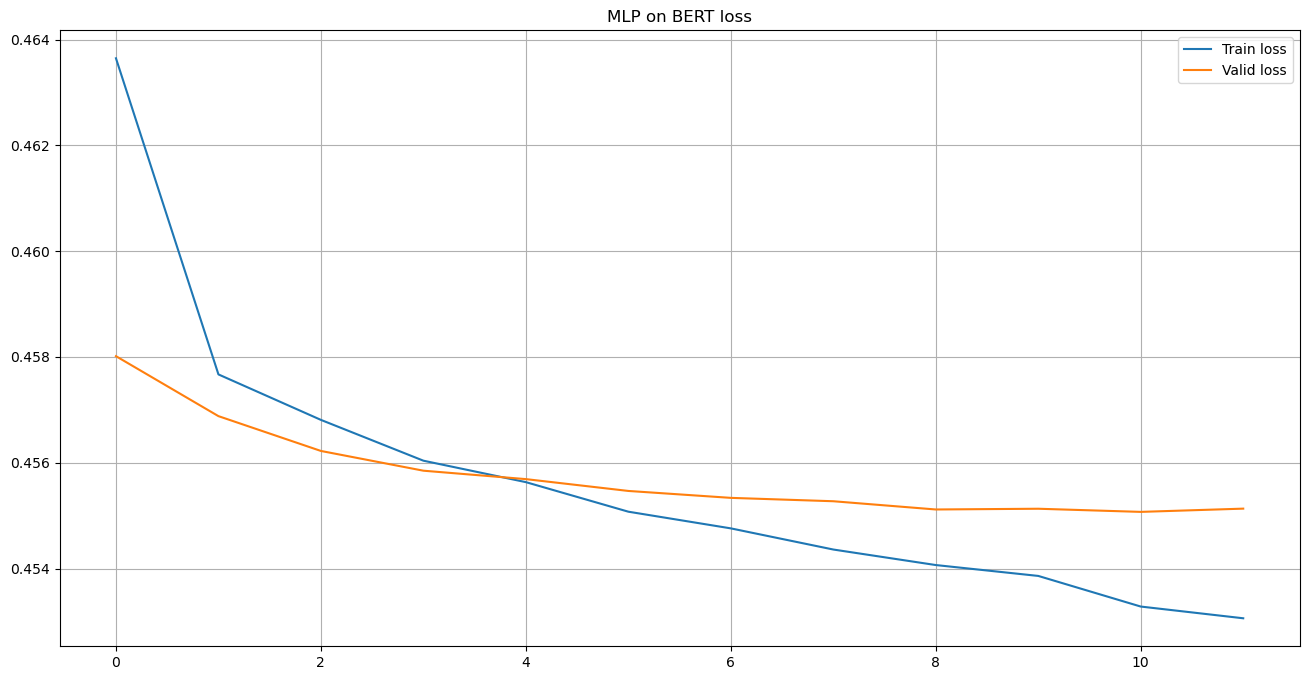

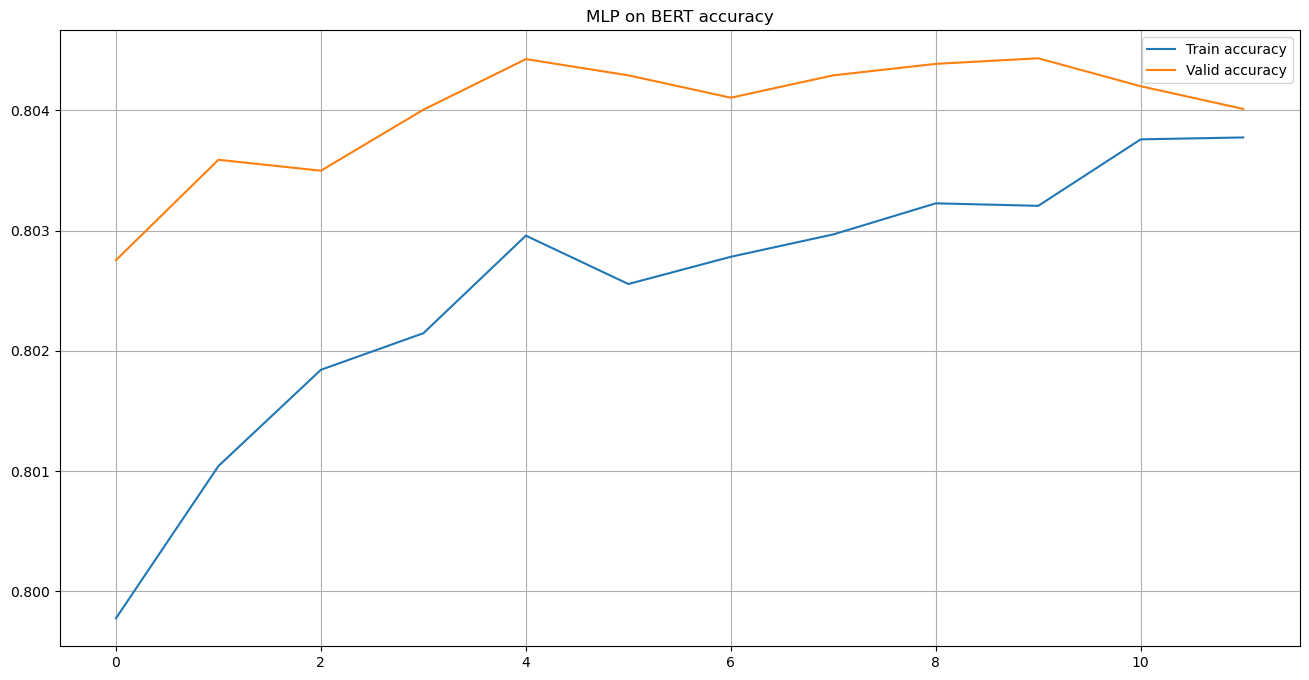

In [74]:
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

little_model = little_model.to(device)

optimizer = Adam(little_model.parameters(), lr=1e-4)
#scheduler = StepLR(optimizer, step_size=20)
loss_fn = nn.BCEWithLogitsLoss()
whole_train_valid_cycle(little_model, 12, 'MLP on BERT')

In [76]:
torch.save(little_model, 'model_01')

### 2nd model

In [164]:
little_model_02 = nn.Sequential(
    nn.Linear(768, 768),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(768, 1)
)

In [166]:
train_labels = torch.as_tensor(df_train['label_1'].values).unsqueeze(1).to(torch.float32)
test_labels = torch.as_tensor(df_test['label_1'].values).unsqueeze(1).to(torch.float32)

dataset = TensorDataset(torch.cat([train_embeddings, test_embeddings], dim=0), torch.cat([train_labels, test_labels], dim=0))

train_dataset, test_dataset = random_split(dataset, (int(len(dataset) * 0.9), len(dataset) - int(len(dataset) * 0.9)))

train_loader = DataLoader(train_dataset, batch_size=128, pin_memory=True, shuffle=False)
valid_loader = DataLoader(test_dataset, batch_size=128, pin_memory=True, shuffle=False)

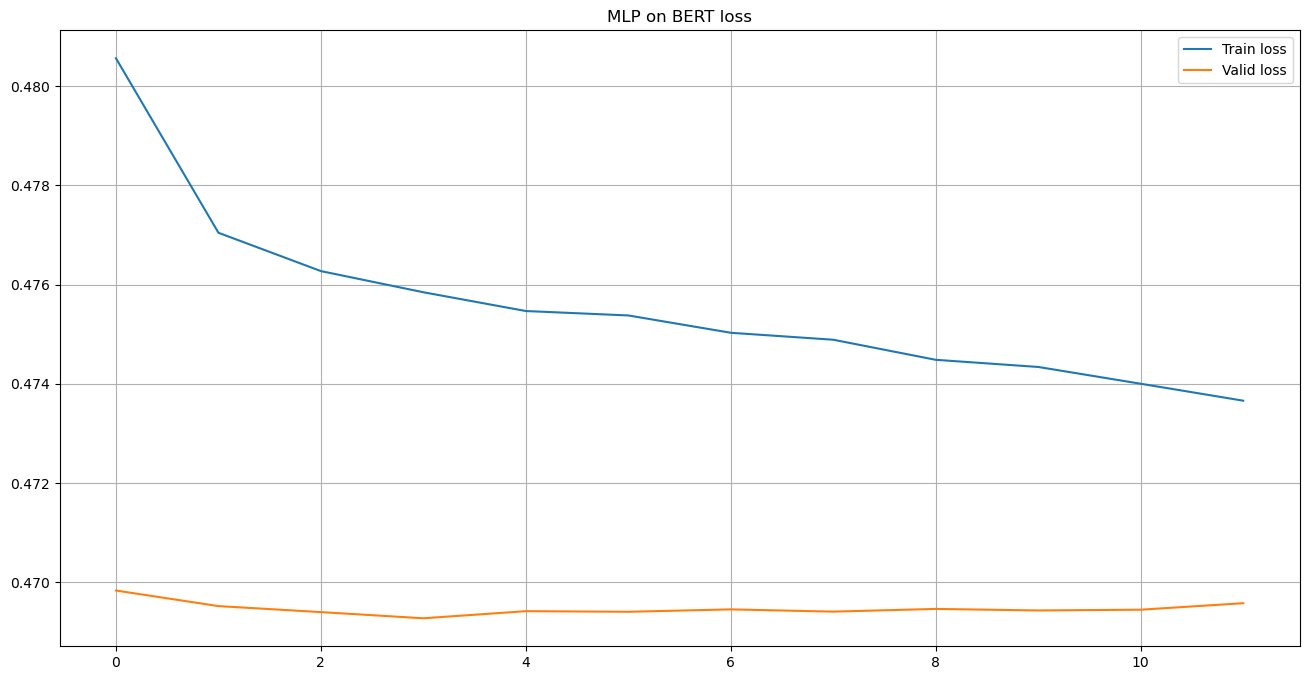

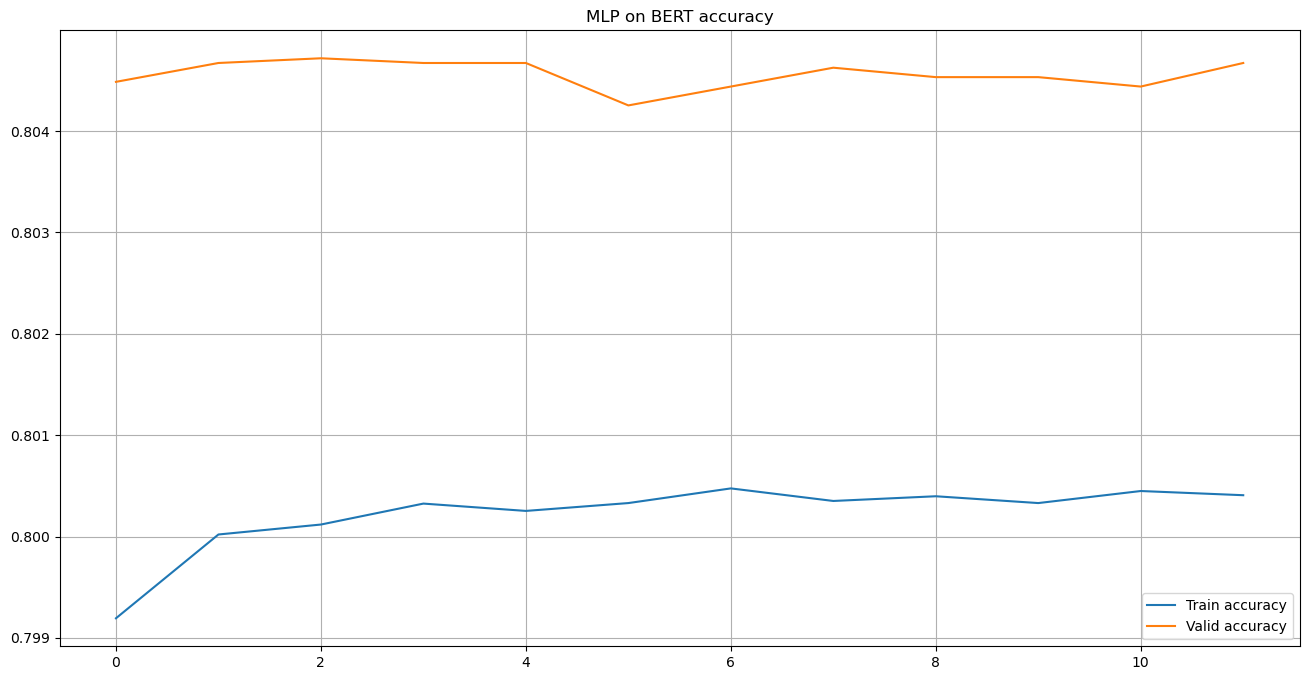

In [167]:
little_model_02 = little_model_02.to(device)

optimizer = Adam(little_model_02.parameters(), lr=1e-4)
#scheduler = StepLR(optimizer, step_size=20)
loss_fn = nn.BCEWithLogitsLoss()
whole_train_valid_cycle(little_model_02, 12, 'MLP on BERT')

In [168]:
torch.save(little_model_02, 'model_02')